In [1]:
# Standard libraries
from joblib import Parallel, delayed
import glob

# Third party libraries
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import SimpleITK as sitk
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import scipy.ndimage
from sklearn.neighbors import KernelDensity

# Our libraries
from gui.gui_shared import auto_contrast

In [2]:
def readTifWrapper(i, file_name):
    """
    i - index for parallel processing
    file_name - file name to open
    """
    image = readTifSection(str(file_name))
    return [i, image]


def readTifSection(file_path):
    """
    Read tif section image using SITK
    """
    image = sitk.ReadImage(str(file_path))
    image = sitk.GetArrayFromImage(image)
    image[image < 0] = 0
    image = image.T
    image = np.flip(image, axis=0)
    image = np.flip(image, axis=1)
    image  = np.squeeze(image)
    return image


def intensity_histogram(image: np.ndarray, bins=10, 
                        max_freq=None, min_intensity=None, max_intensity=None,
                        title='Histogram of intensity values'):
    """
    Plot a histogram of the intensity values in the image
    """
    # Flatten the 3D array into a 1D array
    flattened_image = image.flatten()
    
    # If min_intensity is specified, filter the flattened image
    if min_intensity is not None:
        flattened_image = flattened_image[flattened_image >= min_intensity]
    
    # If max_intensity is specified, filter the flattened image
    if max_intensity is not None:
        flattened_image = flattened_image[flattened_image <= max_intensity]
    
    hist, bin_edges = np.histogram(flattened_image, bins=bins, 
                                   range=(0, max_intensity if max_intensity is not None else np.max(flattened_image)))
    
    # Filter the bins to include only those with frequencies below max_freq if max_freq is not None
    if max_freq is not None:
        mask = hist < max_freq
        filtered_hist = hist[mask]
        filtered_bin_edges = bin_edges[:-1][mask]
        filtered_bin_widths = np.diff(bin_edges)[mask]
    else:
        filtered_hist = hist
        filtered_bin_edges = bin_edges[:-1]
        filtered_bin_widths = np.diff(bin_edges)
    
    # Compute and plot the histogram
    plt.figure(figsize=(6, 4))  # 12, 8
    plt.bar(filtered_bin_edges, filtered_hist, width=filtered_bin_widths, color='skyblue', alpha=0.75, edgecolor='black', align='edge')
    plt.title(title, fontsize=16)
    plt.xlabel('Intensity value', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
  
    # Format the y-axis to display large numbers with commas
    def format_func(value, tick_number):
        return f'{int(value):,}'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    plt.tight_layout()
    plt.show()


def intensity_stats(image: np.ndarray):
    """
    Summary statistics of the intensity values in the image
    """
    print("Image shape:", image.shape)
    flattened_image = image.flatten()
    min_intensity = np.min(flattened_image)
    print(f'Minimum intensity: {min_intensity}')
    max_intensity = np.max(flattened_image)
    print(f'Maximum intensity: {max_intensity}')
    mean_intensity = np.mean(flattened_image)
    print(f'Mean intensity: {mean_intensity}')
    median_intensity = np.median(flattened_image)
    print(f'Median intensity: {median_intensity}')
    #std_intensity = np.std(flattened_image)  # This crashes the PC
    #print(f'Standard deviation: {std_intensity}')
    return min_intensity, max_intensity, mean_intensity, median_intensity



def compute_density_map(image: np.ndarray, bandwidth=1.0, downsample_factor=2):
    """
    Compute a density map of intensity values for an image using kernel density estimation.
    
    Parameters:
    - image: 2D numpy array representing the image.
    - bandwidth: Bandwidth for the kernel density estimation.
    - downsample_factor: Factor by which to downsample the image.
    
    Returns:
    - density_map: 2D numpy array representing the density map.
    """
    # Downsample the image
    downsampled_image = scipy.ndimage.zoom(image, 1.0 / downsample_factor)
    
    # Flatten the downsampled image to get the intensity values
    flattened_image = downsampled_image.flatten().reshape(-1, 1)
    
    # Use KernelDensity from sklearn to compute the density of the intensity values
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(flattened_image)
    
    # Evaluate the density on the intensity values
    density_values = kde.score_samples(flattened_image)
    density_values = np.exp(density_values)  # Convert log density to density
    
    # Reshape the density values back to the downsampled image shape
    density_map_downsampled = density_values.reshape(downsampled_image.shape)
    
    # Upsample the density map back to the original image size
    density_map = scipy.ndimage.zoom(density_map_downsampled, downsample_factor)
    
    return density_map


def count_cells(image):
    """
    Count the number of cells in the image
    """
    return


# Create a histogram of watershed sizes after peak intensity operation

(980, 980, 4)
Initial parameters: [490.0, 490.0, 400, 450, 0]
Optimized parameters: [490. 490. 400. 450.   0.]


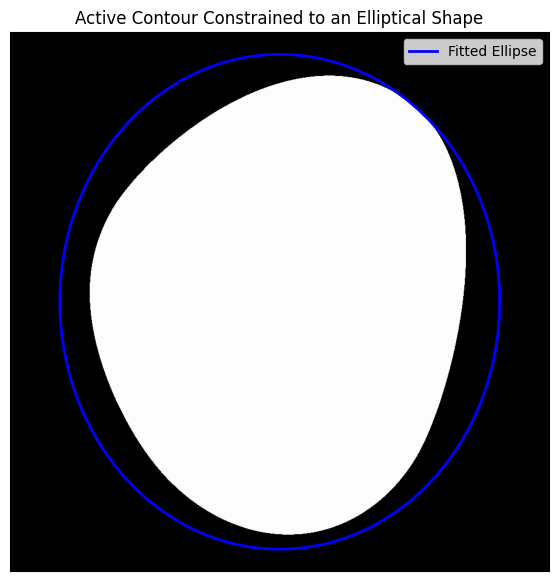

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float, filters
from scipy.optimize import minimize

# Function to create an ellipse based on parameters
def ellipse_param(t, params):
    x0, y0, a, b, theta = params
    x = x0 + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
    y = y0 + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)
    return x, y

# Function to calculate energy based on the image gradient and the ellipse parameters
def energy_function(params, image_gradient, t):
    # Create the ellipse points
    x, y = ellipse_param(t, params)
    # Clip points to image dimensions
    x = np.clip(x, 0, image_gradient.shape[1] - 1).astype(int)
    y = np.clip(y, 0, image_gradient.shape[0] - 1).astype(int)
    # Calculate energy as the sum of gradient magnitudes along the ellipse
    energy = -np.sum(image_gradient[y, x])  # Negative to maximize gradient values (minimize function)
    return energy

# Load and prepare the image
image = img_as_float(io.imread('/media/data/u01/oval.png'))
print(image.shape)
image = image[:, :, :3]
if image.ndim == 3:  # If the image is colored
    image_gray = color.rgb2gray(image)
else:
    image_gray = image


# Calculate image gradient magnitude
image_gradient = filters.sobel(image_gray)

# Initialize parameters for the ellipse: (x0, y0, a, b, theta)
params_initial = [
    image_gray.shape[1] / 2,  # x0: center x
    image_gray.shape[0] / 2,  # y0: center y
    400,                      # a: semi-major axis
    450,                       # b: semi-minor axis
    0                         # theta: rotation angle in radians
]

print("Initial parameters:", params_initial)

# Parameter for the ellipse curve
t = np.linspace(0, 2 * np.pi, 100)

# Minimize the energy function to fit the ellipse to the image
result = minimize(
    energy_function, 
    params_initial, 
    args=(image_gradient, t), 
    method='L-BFGS-B',  # Use a bounded optimization method
    bounds=[(0, image_gray.shape[1]),  # x0 bounds
            (0, image_gray.shape[0]),  # y0 bounds
            (1, image_gray.shape[1] // 2),  # a bounds
            (1, image_gray.shape[0] // 2),  # b bounds
            (-np.pi, np.pi)]  # theta bounds
)

# Extract the optimized parameters
params_optimized = result.x

print("Optimized parameters:", params_optimized)

# Generate the optimized ellipse
x_opt, y_opt = ellipse_param(t, params_optimized)

# Plot the results
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image_gray, cmap=plt.cm.gray)
ax.plot(x_opt, y_opt, '-b', label='Fitted Ellipse', lw=2)
ax.set_title("Active Contour Constrained to an Elliptical Shape")
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
plt.show()

Initial parameters: [256, 256, 128.0, 128.0, 0]
Optimized parameters: [288.90125958 171.89236405 143.63549403  67.16193402   1.30430297]


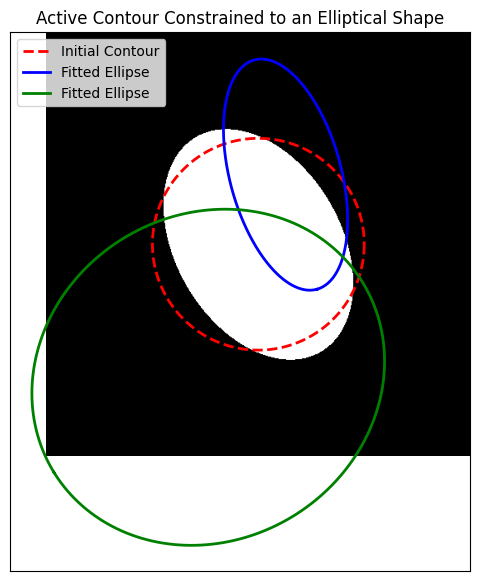

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float, filters
from scipy.optimize import minimize

# Function to create an ellipse based on parameters
def ellipse_param(t, params):
    x0, y0, a, b, theta = params
    x = x0 + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
    y = y0 + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)
    return x, y

# Function to calculate energy based on the image gradient and the ellipse parameters
def energy_function(params, image_gradient, t):
    # Create the ellipse points
    x, y = ellipse_param(t, params)
    # Clip points to image dimensions
    x = np.clip(x, 0, image_gradient.shape[1] - 1).astype(int)
    y = np.clip(y, 0, image_gradient.shape[0] - 1).astype(int)
    # Calculate energy as the sum of gradient magnitudes along the ellipse
    energy = -np.mean(image_gradient[y, x])  # Negative to maximize gradient values (minimize function)
    return energy

from skimage.draw import ellipse

# Parameters for the image
image_size = (512, 512)  # Size of the image
ellipse_center = (image_size[0] // 2, image_size[1] // 2)  # Center of the ellipse
ellipse_axes = (150, 100)  # Lengths of the semi-major and semi-minor axes
ellipse_rotation = np.deg2rad(30)  # Rotation angle in radians

# Create an empty black image
image = np.zeros(image_size, dtype=np.float32)

# Create the coordinates for the ellipse
rr, cc = ellipse(ellipse_center[0], ellipse_center[1], ellipse_axes[0], ellipse_axes[1], rotation=ellipse_rotation, shape=image.shape)

# Set the ellipse pixels to white
image[rr, cc] = 1
image_gray = image

# Calculate image gradient magnitude
image_gradient = filters.sobel(image_gray)

# Improved parameters for the ellipse initialization
center_y, center_x = np.array(image_gray.shape) // 2
a_initial = center_x / 2  # Semi-major axis, initially half the width
b_initial = center_y / 2  # Semi-minor axis, initially half the height
theta_initial = 0  # Initial rotation angle in radians

params_initial = [
    center_x,  # x0: center x
    center_y,  # y0: center y
    a_initial,  # a: semi-major axis
    b_initial,  # b: semi-minor axis
    theta_initial  # theta: rotation angle
]



print("Initial parameters:", params_initial)

# Parameter for the ellipse curve
t = np.linspace(0, 2 * np.pi, 400)

# Generate initial ellipse coordinates
x_init, y_init = ellipse_param(t, params_initial)


# Minimize the energy function to fit the ellipse to the image
result = minimize(
    energy_function, 
    params_initial, 
    args=(image_gradient, t), 
    method='Powell',  # Use Powell's method for improved parameter search
    bounds=[(0, image_gray.shape[1]),  # x0 bounds
            (0, image_gray.shape[0]),  # y0 bounds
            (5, image_gray.shape[1] // 2),  # a bounds
            (5, image_gray.shape[0] // 2),  # b bounds
            (-np.pi, np.pi)]  # theta bounds
)


# Extract the optimized parameters
params_optimized = result.x

print("Optimized parameters:", params_optimized)


# Generate the optimized ellipse
x_opt, y_opt = ellipse_param(t, params_optimized)


# Minimize the energy function to fit the ellipse to the image
curr_params = params_optimized
num_iter = 150
for it in range(num_iter):
    
    result2 = minimize(
        energy_function, 
        curr_params, 
        args=(image_gradient, t), 
        method='Powell',  # Use Powell's method for improved parameter search
        bounds=[(0, image_gray.shape[1]),  # x0 bounds
                (0, image_gray.shape[0]),  # y0 bounds
                (5, image_gray.shape[1] // 2),  # a bounds
                (5, image_gray.shape[0] // 2),  # b bounds
                (-np.pi, np.pi)]  # theta bounds
    )
    curr_params = result2.x


# Generate the optimized ellipse
x_opt2, y_opt2 = ellipse_param(t, curr_params)

# Plot the results
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image_gray, cmap=plt.cm.gray)
ax.plot(x_init, y_init, '--r', label='Initial Contour', lw=2)
ax.plot(x_opt, y_opt, '-b', label='Fitted Ellipse', lw=2)
ax.plot(x_opt2, y_opt2, '-g', label='Fitted Ellipse', lw=2)
ax.set_title("Active Contour Constrained to an Elliptical Shape")
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
plt.show()
